The code in this notebook is based on the blog https://gilberttanner.com/blog/fastai-image-segmentation

In [1]:
import os

In [2]:
print(os.getcwd())

/home/prarit/MachineLearningProjects/computer-vision-segmentation


In [3]:
from fastai.vision import*

In [4]:
path = untar_data(URLs.CAMVID_TINY)
print(path.ls())

[PosixPath('/home/prarit/.fastai/data/camvid_tiny/codes.txt'), PosixPath('/home/prarit/.fastai/data/camvid_tiny/images'), PosixPath('/home/prarit/.fastai/data/camvid_tiny/labels')]


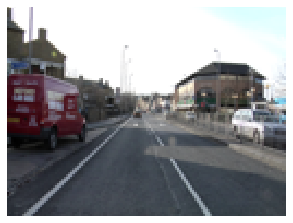

In [5]:
path_lbls = path/'labels'
path_imgs = path/'images'

fnames = get_image_files(path_imgs)
lbl_names = get_image_files(path_lbls)

# picking a random image from the dataset
img_f = fnames[10]
img = open_image(img_f)
img.show(figsize = (5,5))

In [6]:
# file containing the segmentation mask
get_y_fn = lambda x: path_lbls/f'{x.stem}_P{x.suffix}'
print(get_y_fn(img_f))

/home/prarit/.fastai/data/camvid_tiny/labels/0016E5_00840_P.png


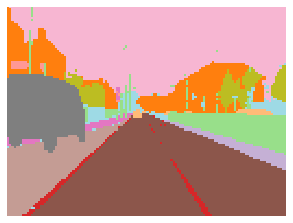

In [7]:
# viewing the file containing the segmentation
img_mask = open_mask(get_y_fn(img_f))
img_mask.show(figsize = (5,5), alpha = 1)

In [8]:
img_mask.data

tensor([[[ 4, 21, 21,  ..., 21, 21, 21],
         [ 4,  4, 21,  ..., 21, 21, 21],
         [ 4,  4, 21,  ..., 21, 21, 21],
         ...,
         [18, 18, 18,  ..., 17, 17, 17],
         [18, 18, 18,  ..., 17, 17, 17],
         [18, 18, 18,  ..., 17, 17, 17]]])

In [9]:
# instead of using FastAI's open_mask method to view the image with the segmentation mask, we can 
# simply use imread method of imageio module
import imageio
import matplotlib.pyplot as plt

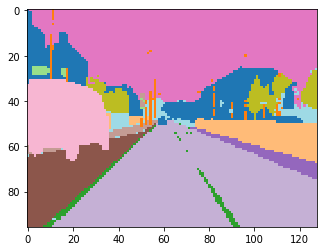

In [10]:
im2 = imageio.imread(get_y_fn(img_f))
plt.imshow(im2, cmap =  'tab20')
plt.show()

In [11]:
im2

Array([[ 4, 21, 21, 21, ..., 21, 21, 21, 21],
       [ 4,  4, 21, 21, ..., 21, 21, 21, 21],
       [ 4,  4, 21, 21, ..., 21, 21, 21, 21],
       [ 4,  4, 21, 21, ..., 21, 21, 21, 21],
       ...,
       [18, 18, 18, 18, ..., 17, 17, 17, 17],
       [18, 18, 18, 18, ..., 17, 17, 17, 17],
       [18, 18, 18, 18, ..., 17, 17, 17, 17],
       [18, 18, 18, 18, ..., 17, 17, 17, 17]], dtype=uint8)

In [12]:
# the classes of various masks
codes = np.loadtxt(path/'codes.txt', dtype=str); 
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [13]:
src_size = np.array(img_mask.shape[1:])
size = src_size//2
bs = 64

In [14]:
src = (SegmentationItemList.from_folder(path_imgs)
       # Load in x data from folder
       .split_by_rand_pct(valid_pct=0.2,seed=4) 
       # Split data into training and validation set 
       .label_from_func(get_y_fn, classes=codes)
       # Label data using the get_y_fn function
)

data = (src.transform(get_transforms(), size=size, tfm_y=True) # tfm_y = True applies the same transformations to the target images also
        # Flip images horizontally 
        .databunch(bs=bs)
        # Create a databunch
        .normalize(imagenet_stats)
        # Normalize for resnet
)

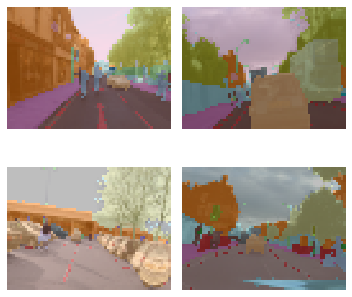

In [15]:
# sample of a few image masks
data.show_batch(rows=2, figsize=(5,5))

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

#def acc_camvid(input, target):
#    target = target.squeeze(1)
#    mask = target != void_code
#    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def acc_camvid(inp, target):
    target = target.squeeze(1)
    return (inp.argmax(dim=1)==target).float().mean()

In [17]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


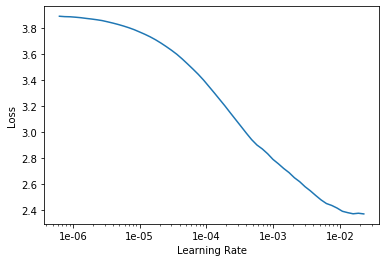

In [18]:
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate graph

In [19]:
lr = 1e-3 # pick a lr
learn.fit_one_cycle(20, slice(lr), pct_start=0.9) # train model

epoch,train_loss,valid_loss,acc_camvid,time
0,3.890284,3.389658,0.027669,00:05
1,3.697493,3.157411,0.078467,00:06
2,3.549554,2.915947,0.221533,00:06
3,3.404670,2.638153,0.420898,00:05
4,3.240396,2.434898,0.523096,00:06
5,3.106048,2.127034,0.566276,00:06
6,2.963277,1.917677,0.579622,00:06
7,2.827643,1.816757,0.575765,00:06
8,2.702200,1.682976,0.585531,00:06
9,2.585298,1.992070,0.476579,00:06


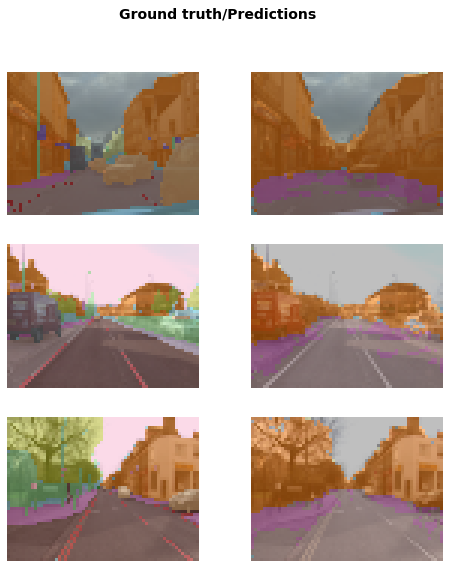

In [20]:
learn.save('camvid-stage-1') # save model
learn.show_results(rows=3, figsize=(8, 9)) # show results

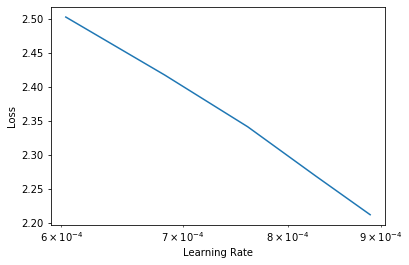

In [21]:
learn.unfreeze() # unfreeze all layers

# find and plot lr again
learn.unfreeze()
learn.recorder.plot()

In [22]:
# train model 
learn.fit_one_cycle(12, slice(lr/400, lr/4), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.280390,1.394375,0.623877,00:06
1,1.257271,1.367822,0.629069,00:06
2,1.245149,1.333490,0.631624,00:07
3,1.234114,1.318878,0.628499,00:06
4,1.225449,1.315551,0.628060,00:07
5,1.225304,1.294128,0.634863,00:06
6,1.215051,1.297233,0.640983,00:07
7,1.205641,1.304201,0.643473,00:07
8,1.196850,1.274011,0.650407,00:07
9,1.185549,1.250140,0.657910,00:06


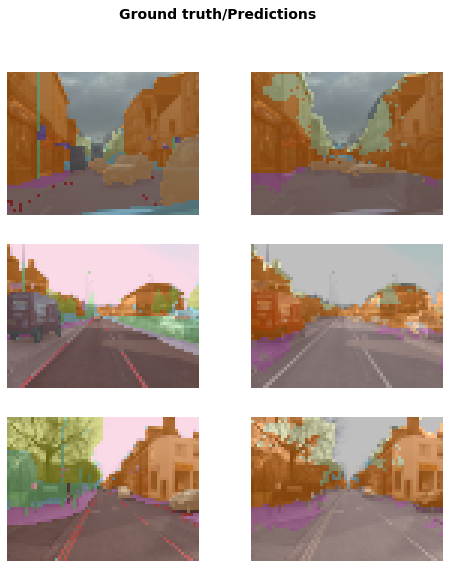

In [23]:
learn.save('camvid-stage-2') # save model
learn.show_results(rows=3, figsize=(8, 9)) # show results